This notebook demonstrates our graph network inductive bias with a symbolic model extraction.

# Preamble and data generation

## Make sure to turn on the GPU via Edit-> Notebook settings. 

In [25]:
#Basic pre-reqs:
import numpy as np
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

os.environ['CUDA_LAUNCH_BLOCKING'] = str(1) 

## Download pre-reqs, and then code for simulations and model files:

(Note: installing torch-geometric may take a long time.)

In [26]:
!pip install celluloid

In [27]:
version_nums = torch.__version__.split('.')
# Torch Geometric seems to always build for *.*.0 of torch :
version_nums[-1] = '0' + version_nums[-1][1:]
os.environ['TORCH'] = '.'.join(version_nums)
 
!pip install --upgrade torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu102.html
Requirement already up-to-date: torch-scatter in /home/ozkilim/.local/lib/python3.8/site-packages (2.1.0+pt112cu102)
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu102.html
Requirement already up-to-date: torch-sparse in /home/ozkilim/.local/lib/python3.8/site-packages (0.6.15+pt112cu102)
Requirement already up-to-date: torch-geometric in /home/ozkilim/.local/lib/python3.8/site-packages (2.1.0.post1)


In [28]:
import models
import simulate
# problem with compatability of packages

## Assert we have a GPU:

In [29]:
torch.ones(1).cuda()

tensor([1.], device='cuda:0')

## Create the simulation:

In [30]:
# Number of simulations to run (it's fast, don't worry):
ns = 95
# Potential (see below for options)
sim = 'lj'
# Number of nodes
n = 6
# Dimension
dim = 3
# Number of time steps
nt = 1000

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
 {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
 {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'lj', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},

]

#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
print('Running on', title)

Running on lj_n=6_dim=3_nt=1000_dt=0.01


## Generate simulation data:

In [31]:
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
# Update this to your own dataset, or regenerate:

base_str = './'
data_str = title
s.simulate(ns)
# inspect the structure here and load up the pidgeon flight data...

In [32]:
print(type(s.data))
# 10000 simulations, 500 frames each, 4 particles, 6 values for each particle?

<class 'jaxlib.xla_extension.DeviceArray'>


### Let's visualize an example simulation:

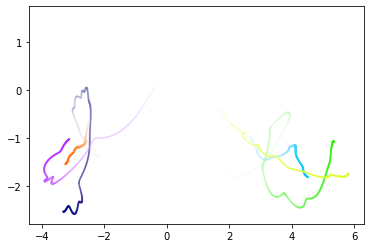

In [57]:
from celluloid import Camera

s.plot(3, animate=True, plot_size=False) #save this for readme
# camera.animate().save('multiple_animations_with_comparison.mp4')
# fig = plt.gcf()
# camera = Camera(fig)

# animation = camera.animate()
# animation.save('../animations/lj.gif',fps=10)

## We'll train on the accelerations, so let's generate the dataset:

In [34]:
accel_data = s.get_acceleration()
print(accel_data.shape)
print(type(accel_data))

(95, 500, 6, 3)
<class 'jaxlib.xla_extension.DeviceArray'>


In [35]:
# try with our own real data now...

# accel_data = np.load("../vicek_sim/flight_acells.npy").astype(np.float32)
# s.data = np.load("../vicek_sim/flight_feats.npy").astype(np.float32)

X = torch.from_numpy(np.concatenate([s.data[:, i] for i in range(0, s.data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, s.data.shape[1], 5)]))

data = s.data #important to keep!

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

print(X.shape)
print(y.shape)
# inspect the form of the data here! 6 features for train and 2 for test?

torch.Size([9500, 6, 8])
torch.Size([9500, 6, 3])


# Set up the model

In [38]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [39]:
from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

## Use the L1 regularization model:

In [40]:
aggr = 'add'
hidden = 500 #was 300

test = '_l1_' #turn off regulerisation to try to overfit at the start...
# test = _l1_
#This test applies an explicit bottleneck:

msg_dim = 100 
n_f = data.shape[3]

L1 loss: we simply add the loss to the batch number. I.e., * 32 for batch size 32.

KL loss: model the messages as a distribution with the prior a Gaussian. The means add in the final Gaussian. 
Recall in the D_KL(p||q), the prior is q.  Then, for sigma_q = 1, mu_q = 0, we have ($p=1$):

$$D_{KL}(p||q) = \frac{\sigma_p^2 + \mu_p^2}{2} -\log({\sigma_p}) - \frac{1}{2}$$

## We use a custom data loader for the graphs for fast training:

In [41]:
from torch_geometric.data import Data, DataLoader

In [42]:
from models import get_edge_index

In [43]:
edge_index = get_edge_index(n, sim)

## Initiate the model:

In [44]:
if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

messages_over_time = []
ogn = ogn.cuda()

### Let's test it:

In [45]:
_q = Data(
    x=X_train[0].cuda(),
    edge_index=edge_index.cuda(),
    y=y_train[0].cuda())

ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 

(tensor([[ 0.0518, -0.2082,  0.0962],
         [ 0.0100, -0.0460,  0.0553],
         [-0.0027, -0.0162,  0.0375],
         [ 0.0062, -0.0127,  0.0548],
         [-0.0139, -0.0254,  0.0699],
         [ 0.0094, -0.0348,  0.0635]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 torch.Size([6, 3]),
 torch.Size([6, 3]),
 tensor(104.4319, device='cuda:0', grad_fn=<SumBackward0>))

# Set up training

## Organize into data loader:

In [46]:
batch = int(64 * (4 / n)**2)
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

/home/ozkilim/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## We'll use OneCycleLR for fast training:

In [47]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

## Create the loss function

This holds definition of our L1 and KL regularizations:

In [48]:
def new_loss(self, g, augment=True, square=False):
    if square:
        return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
    else:
        base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
        if test in ['_l1_', '_kl_']:
            s1 = g.x[self.edge_index[0]]
            s2 = g.x[self.edge_index[1]]
            if test == '_l1_':
                m12 = self.message(s1, s2)
                regularization = 1e-2
                #Want one loss value per row of g.y:
                normalized_l05 = torch.sum(torch.abs(m12))
                return base_loss, regularization * batch * normalized_l05 / n**2 * n
            elif test == '_kl_':
                regularization = 1
                #Want one loss value per row of g.y:
                tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
                raw_msg = self.msg_fnc(tmp)
                mu = raw_msg[:, 0::2]
                logvar = raw_msg[:, 1::2]
                full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
                return base_loss, regularization * batch * full_kl / n**2 * n
        return base_loss

## Set up optimizer and training parameters:

**Use 200 epochs for full version; can use fewer for test.**

In [49]:
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

total_epochs = 50
# total_epochs = 30

batch_per_epoch = int(1000*10 / (batch/32.0))

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

11428

In [50]:
epoch = 0

In [51]:
from tqdm import tqdm

## Organize the recording of messages over time

This is for fitting the forces, and extracting laws:

In [52]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

### Function to record messages from model

In [53]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info

In [54]:
recorded_models = []

# Train the model:

## Training loop:

In [55]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cuda()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.cuda()
            ginput.y = ginput.y.cuda()
            ginput.edge_index = ginput.edge_index.cuda()
            ginput.batch = ginput.batch.cuda()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss) #can we view the training loss to check its working?... looks thike this is the train loss?...
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(ogn.state_dict())

  0%|          | 0/50 [00:06<?, ?it/s]


KeyboardInterrupt: 

Normally you should run all the way to 200 epochs (set this as a parameter so that OneCycleLR is set correctly). This loop was cut off early to quickly test this notebook.

## Save and Load models here to prevent re-training:

In [ ]:
import pickle as pkl
pkl.dump(messages_over_time,
    open('../data/messages_over_time_lj.pkl', 'wb'))
messages_over_time = pkl.load(open('../data/messages_over_time_lj.pkl', 'rb'))

In [ ]:
pkl.dump(recorded_models,
    open('../data/models_over_time_lj.pkl', 'wb'))

recorded_models = pkl.load(open('../data/models_over_time_lj.pkl', 'rb'))

# Analyze trained model:

## Plot a comparison of the force components with the messages:

### (Or plot the rotation or sparsity - turn these on and off with flags:)

In [ ]:
from celluloid import Camera
from copy import deepcopy as copy

Options include:

- plot_force_components: the scatter plots of true force versus message
- plot_sparsity: the grayscale animation of the message components over time
- plot_rotation: plot the vectors showing how the messages are rotations of the true vectors

In [ ]:

#Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    msgs = copy(messages_over_time[i])

    msgs['bd'] = msgs.r + 1e-2

    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        if sim != 'spring':
            raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")
        force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]

        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
    
from IPython.display import HTML
HTML(ani.to_jshtml())

## Plot some predicted versus true trajectories:

In [ ]:
from simulate import make_transparent_color

In [ ]:
from scipy.integrate import odeint

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
    i = 0 #which video to use. 5 is interesting
    if current_model > len(recorded_models):
        continue
    
    #Truth:
    cutoff_time = 300
    times = onp.array(s.times)[:cutoff_time]

    print(data.shape) # this is not our data!

    x_times = onp.array(data[i, :cutoff_time])
    length_of_tail = 75

    #Learned:
    e = edge_index.cuda()
    ogn.cpu()
    # if current_model > -1:
    #     print("using model")
    ogn.load_state_dict(recorded_models[current_model])
    
    # else:
    #     # Random model!
    # ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
    ogn.cuda()
    
    def odefunc(y, t=None):
        # print(y.shape) 48
        y = y.reshape(6, 8).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cuda(),
            edge_index=e
        )
        dx = y[:, 3:6] #actually not 2:4 its 
        # dv = y[:, 6:6]
        dv = ogn.just_derivative(cur).cpu().detach().numpy()
        # print(dv) # this output is always the same! does not change as a function of the state of the system..  try random
        # dother = np.zeros_like(dx)
        dother = np.zeros((6,2))
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    # Make predictions and back into simulations
    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, 6, 8)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

        # for k in range(2):
        #     ax[k].set_xlim(-1, 3)
        #     ax[k].set_ylim(-3, 1)
        plt.tight_layout()
        camera.snap()
    # break

from IPython.display import HTML
HTML(camera.animate().to_jshtml())

animation = camera.animate()
animation.save('../animations/predictiosns_lj.gif',fps=10)
# plot some stats of acceleraions for all the videos... to see the distrribtution we are learning...

# Symbolic regression

Extract the force laws with the following procedure:
- The data in `messages_over_time` correspond to inputs to, and features of, $\phi^e$, recorded during each training epoch.
- Select the last element of this list.
- Find the most significant message feature. Each message feature corresponds to 'e1', 'e2', etc. Calculate the one with the largest standard deviation.

Train [PySR](https://github.com/MilesCranmer/PySR) to fit this relationship.
Thus, we have extracted a force law from the graph network without priors on the functional form.

This is the same technique we used to extract the unknown dark matter overdensity equation from the Quijote simulations.


## Here's the best message, which we will study:

In [ ]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])

## Here's a pandas dataframe of the message data:

In [ ]:
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']] # adjust this to fit our form. first train on fullscale dataset.....

## Now we just fit e4 as a function of dx, dy, r, m1, and m2, inside [PySR](https://github.com/MilesCranmer/PySR).